## Solving combinatorial optimization problems using QAOA


### Combinatorial Optimization Problem


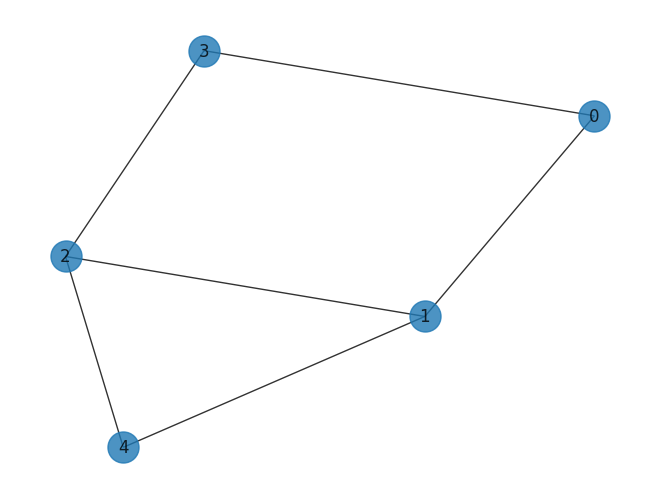

In [93]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

## Hardware Grid

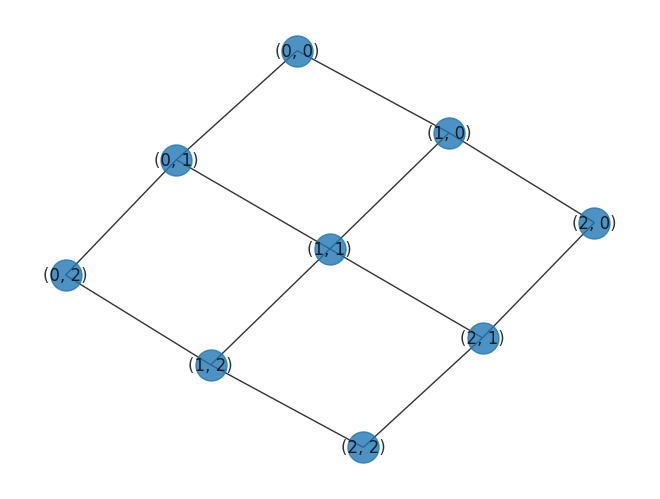

In [94]:
# Create a 2D grid graph
graph = nx.grid_2d_graph(3, 3)

# Draw the graph
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### Three-Regular Problem

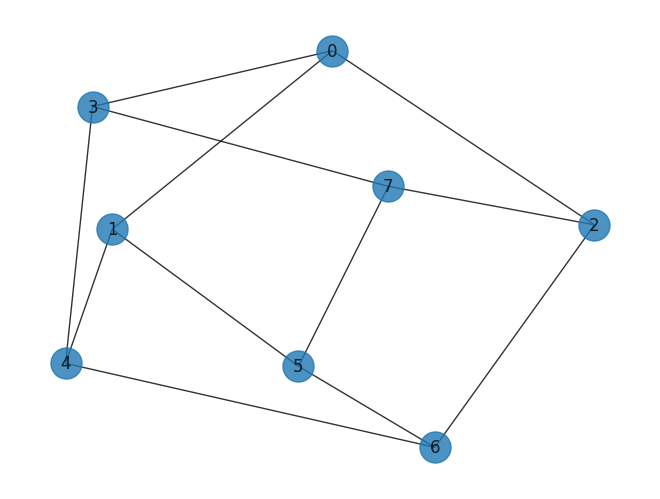

In [95]:
# Create a graph
graph = nx.Graph()

# Add nodes
graph.add_nodes_from(range(8))  # This will add nodes 0 to 7

# Add edges to form a 3-regular graph
graph.add_edges_from([(0, 1), (0, 2), (0, 3), 
                      (1, 4), (1, 5), 
                      (2, 6), (2, 7), 
                      (3, 4), (3, 7), 
                      (4, 6), 
                      (5, 6), (5, 7)])

# Draw the graph
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### Sherrington-Kirkpatrick (SK) model 

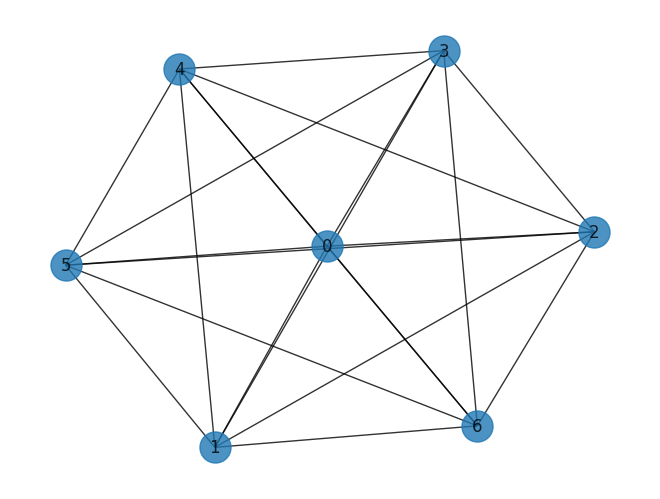

In [96]:
# Number of nodes (spins) in the SK model
num_nodes = 7

# Create a fully connected graph
graph = nx.complete_graph(num_nodes)

# Draw the graph
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### The Problem Unitary (Hamiltonian)

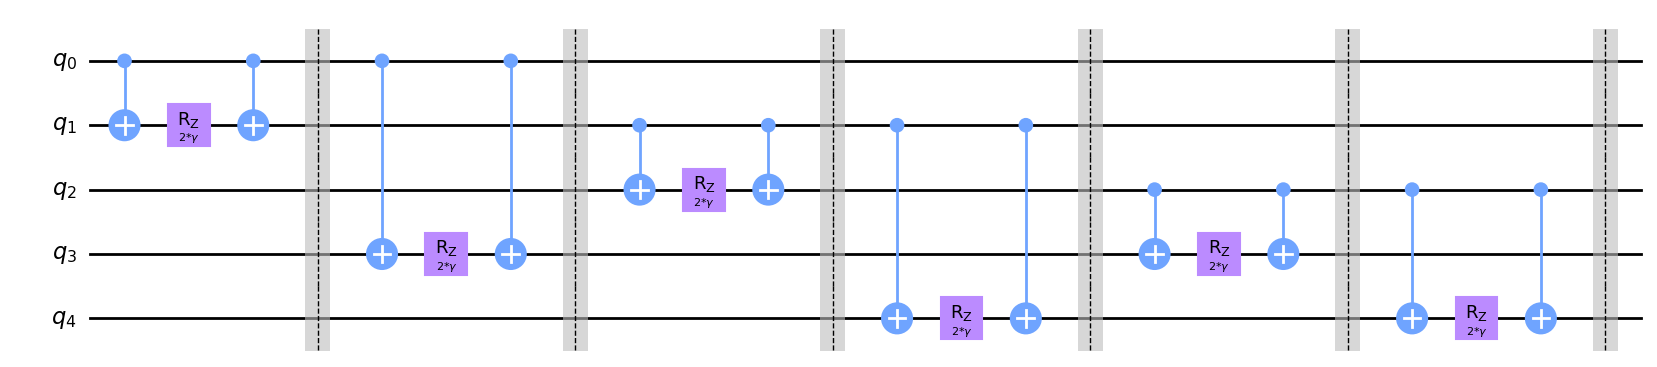

In [67]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

### The Mixing Unitary (Hamiltonian)

/tmp/ipykernel_7518/963588246.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(graph).todense()


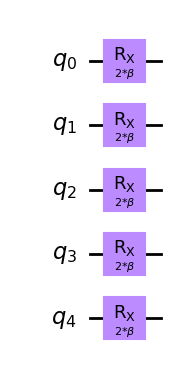

In [68]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 5

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

## Initial State

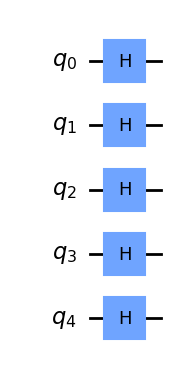

In [69]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw()

### The QAOA circuit

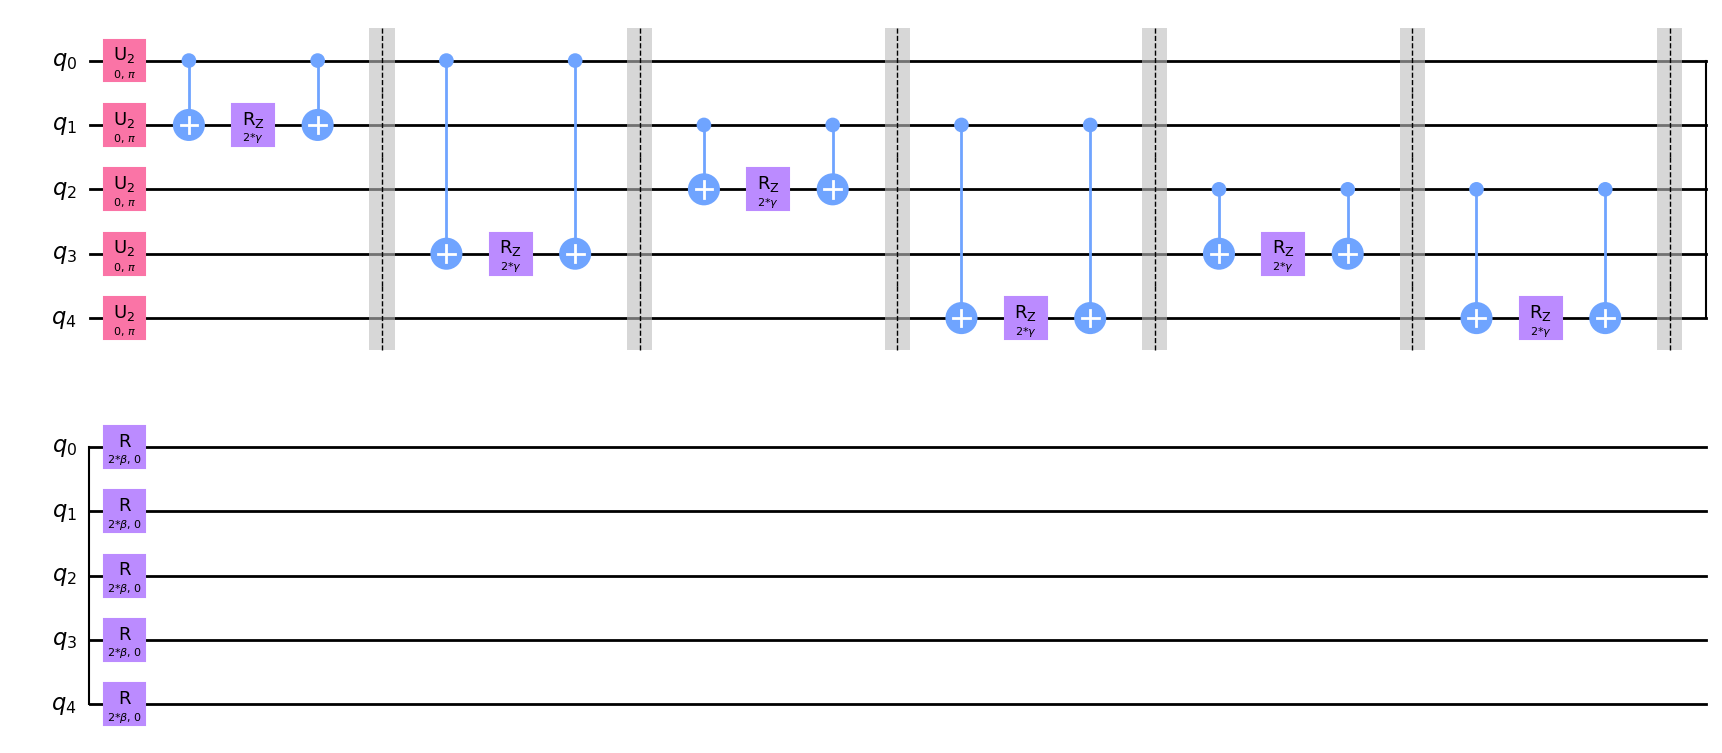

In [70]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

In [88]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
            #print('gamma: ',gamma[layer_index])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
            #print('beta', beta[layer_index])

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=4096):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=4096).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [89]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

     fun: -3.6435546875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.83201126, 0.27753265])

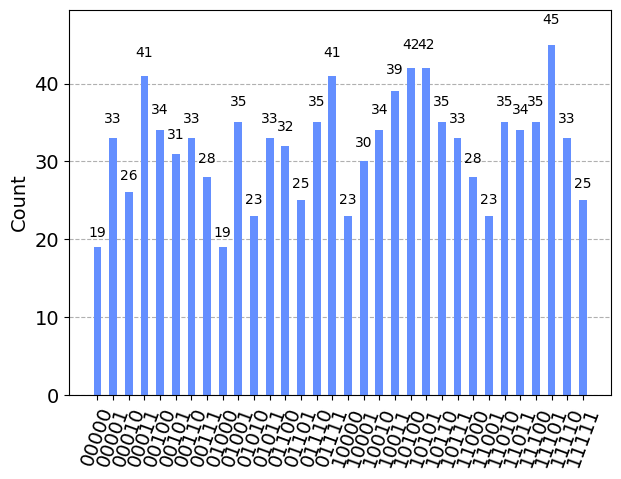

In [91]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 4096

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, theta)
counts = backend.run(qc_res, seed_simulator=123).result().get_counts()
plot_histogram(counts)

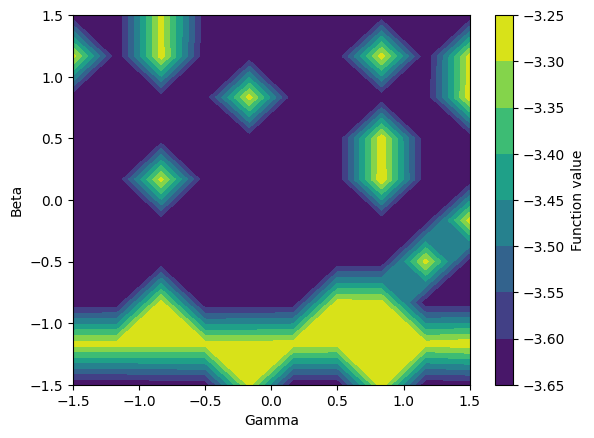

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import pi

# Define the range of gamma and beta values
gamma_values = np.linspace(-1.5, 1.5, 10)
beta_values = np.linspace(-1.5, 1.5, 10)

# Initialize an array to store the function values
fun_values = np.zeros((len(gamma_values), len(beta_values)))

# Run the QAOA circuit for each pair of gamma and beta values
for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        theta = [beta, gamma]
        expectation = get_expectation(graph)
        res = minimize(expectation, theta, method='COBYLA')
        fun_values[i, j] = res.fun

# Create the contour plot
plt.contourf(gamma_values, beta_values, fun_values)
plt.colorbar(label='Function value')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.show()

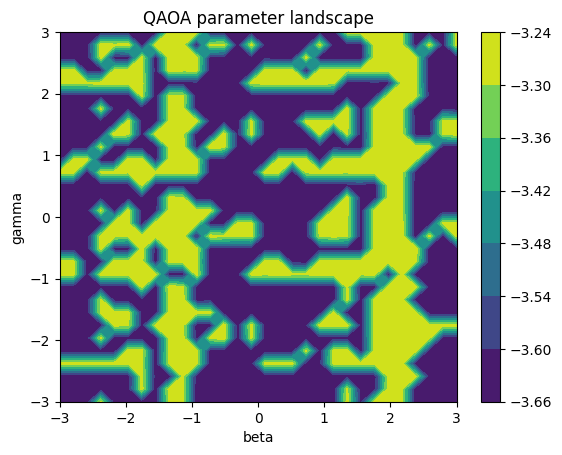

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of parameters to explore
beta_values = np.linspace(-3, 3, 30)
gamma_values = np.linspace(-3, 3, 30)

# Initialize an array to store the results
results = np.zeros((len(beta_values), len(gamma_values)))

# Loop over all combinations of parameters
for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        # Run the QAOA algorithm with these parameters
        result = minimize(expectation, [beta, gamma], method='COBYLA')
        # Store the result
        results[i, j] = result.fun

# Plot the results
plt.contourf(beta_values, gamma_values, results)
plt.colorbar()
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('QAOA parameter landscape')
plt.show()